In [51]:
import matplotlib.pyplot as plt
import datetime
import os
import numpy as np
import scipy
from scipy.integrate import simps
import math

## visualization for basic GPU power consumption

In [52]:
def parse_txt_args(filename):
    file_args = os.path.basename(filename).split('_')   # e.g. gpu_pwr_plain_T4_0_50_9_32.txt
    algo = file_args[2]
    device = file_args[3]
    size = file_args[6]
    threads = file_args[7]
    separator = '.'
    threads = threads.split(separator, 1)[0]
    return algo, device, size, threads

In [70]:
def get_pwr_elapsed_times(lines):
    pwr = []
    timestamps = []
    for i, line in enumerate(lines):
        if i == 0 or line.startswith('#') or line.startswith('COMPLETED'):
            continue
        vals = line.strip().split(',')
        timestamp_str = vals[0]
        y_val = float(vals[1])
        timestamp = datetime.datetime.strptime(timestamp_str, '%Y/%m/%d %H:%M:%S.%f')
        timestamps.append(timestamp)
        pwr.append(y_val)
    
    start_time = timestamps[0]
    elapsed_times = [(t - start_time).total_seconds()*1000 for t in timestamps]
    return pwr, elapsed_times

In [54]:
def compute_energy(pwr, elapsed_times):
    energy = simps(pwr, elapsed_times)/1000
    runtime = max(elapsed_times)/1000 - 6
    return energy, runtime

In [55]:
def get_power_baseline(pwr):
    sample = int(3000/50)   # average power of the first 3 seconds
    baseline = sum(pwr[0:sample])/(sample)
    return baseline

In [56]:
def normalize_power(baseline, pwr, elapsed_times):
    return compute_energy([p-baseline for p in pwr], elapsed_times)[0]

In [75]:
def orgranize_data(dir_name):
    directory = os.fsencode(dir_name)
    plain = dict()
    naive = dict()
    naive_A100 = dict()
    coalesced = dict()
    energy_runtime = dict()
    
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith('.txt'):
            algo, device, size, threads = parse_txt_args(filename)
            with open('../data/correct/'+filename, 'r') as f:
                lines = f.readlines()
                pwr, elapsed_times = get_pwr_elapsed_times(lines)
                energy, runtime = compute_energy(pwr, elapsed_times)
                baseline = get_power_baseline(pwr)
                normalized = normalize_power(baseline, pwr, elapsed_times)
                print('algo:%s, device:%s, size:%s, threads:%s, energy:%.2f, normalized:%.2f, baseline:%.2f, runtime:%.2f'
                      %(algo, device, size, threads, energy, normalized, baseline, runtime))
                if device == 'A100':
                    naive_A100[size] = [pwr, elapsed_times]
                else:
                    k = algo+' '+size+' '+threads
                    energy_runtime[k] = (normalized, runtime)
                    k2 = size+'_'+threads
                    if algo == 'plain':
                        plain[size] = [pwr, elapsed_times]
                    elif algo == 'naive':
                        naive[k2] = [pwr, elapsed_times]
    return plain, naive, naive_A100, energy_runtime


In [58]:
def pad(y, target_len):
    return y + (target_len-len(y))*[None]

In [108]:
def same_size_data(plain, naive):
    longest = len(plain['11'][0])
    plain_list = [plain['9'][0], plain['10'][0], plain['11'][0]]
    naive_list = [naive['9_32'][0], naive['10_32'][0], naive['11_32'][0],
                  naive['9_16'][0], naive['10_16'][0], naive['11_16'][0],
                  naive['9_8'][0], naive['10_8'][0], naive['11_8'][0]]
    plain_padded = []
    naive_padded = []
    for i, p in enumerate(plain_list):
        if len(p) < longest:
            plain_padded.append(pad(p, longest))
        else:
            plain_padded.append(p)
    for i, n in enumerate(naive_list):
        if len(n) < longest:
            naive_padded.append(pad(n, longest))
        else:
            naive_padded.append(n)
    return plain_padded, naive_padded, plain['11'][1]

In [109]:
def compare_same_size(naive, naive_A100, s):
    pwrs = [naive[s][0], naive_A100[s][0]]
    elapsed_times = [naive[s][1], naive_A100[s][1]]
    max_p = max([len(p) for p in pwrs])
    max_e = 0
    times = None
    pwrs_padded = []
    for i, p in enumerate(pwrs):
        if len(p) < max_p:
            pwrs_padded.append((pad(p, max_p), i))
        else:
            pwrs_padded.append((p, i))
    for e in elapsed_times:
        if len(e) > max_e:
            max_e = len(e)
            times = e
    return pwrs_padded, times

In [123]:
def gen_plot(plain_padded, naive_padded, times, title):
    size_idx = {0: '9', 1:'10', 2:'11'}
    thread_idx = {2: '32', 5:'16', 8:'8'}
    size_legend = {'9': '512x512', '10':'1024x1024', '11':'2048x2048'}
    
    fig = plt.figure(figsize=(20, 8))        
    x_ticks = range(int(min(times)), int(max(times))+1, 50000)
    plt.xticks(x_ticks)
    for i in range(len(plain_padded)):
        size = size_legend[size_idx[i]]
        legend = 'plain: ' + size
        plt.plot(times, plain_padded[i], label=legend)
    for i in range(len(naive_padded)):
        if i<=2:
            thread = thread_idx[2]
        elif i>2 and i<=5:
            thread = thread_idx[5]
        else:
            thread = thread_idx[8]
        size = size_legend[size_idx[i%3]]
        legend = 'naive: '+ size +' , block size='+thread
        plt.plot(times, naive_padded[i], label=legend)
    plt.xlabel('Time (ms)')
    plt.ylabel('Power Consumption (W)')
    plt.title(title)
    plt.legend()
    plt.show()

In [124]:
def compare_plot(pwrs, times, s, xtick, title):
    gpu_i = {0:'T4', 1:'A100'}
    size_i = {'9': '512x512', '10':'1024x1024', '11':'2048x2048'}
    
    fig = plt.figure(figsize=(10, 6))        
    # x_ticks = range(int(min(times)), int(max(times))+1, xtick)
    # plt.xticks(x_ticks)
    for i in range(len(pwrs)):
        plt.plot(times, pwrs[i][0], label=gpu_i[pwrs[i][1]])
    plt.xlabel('Time (ms)')
    plt.ylabel('Power Consumption (W)')
    plt.title(title+size_i[s]+'')
    plt.legend()
    plt.show()

In [125]:
def compare_gpu(naive, naive_A100):
    xticks = {'10':3000, '11':30000}
    title = 'Matrix Multiplication with Naive Parallelism on Different GPUs - Matrix dimension: '
    for s, xtick in xticks.items():
        pwrs, times = compare_same_size(naive, naive_A100, s)
        compare_plot(pwrs, times, s, xtick, title)

In [126]:
def get_gradient(x, y):
    return np.polyfit(x, y, 1)

In [127]:
def plot_energy_runtime(energy_runtime):
    plain_x = []
    plain_y = []
    naive_x = []
    naive_y = []
    for k, v in energy_runtime.items():
        x = k.split(' ')
        algo = x[0]
        size = x[1]
        threads = x[2]
        energy, runtime = v
        if algo == 'plain':
            plain_x.append(runtime)
            plain_y.append(energy)
        elif algo == 'naive':
            naive_x.append(runtime)
            naive_y.append(energy)
    
    plain_z = np.polyfit(plain_x, plain_y, 3)
    plain_f = np.poly1d(plain_z)
    plain_y_new = plain_f(plain_x)
    naive_z = np.polyfit(naive_x, naive_y, 3)
    naive_f = np.poly1d(naive_z)
    naive_y_new = naive_f(naive_x)
    fig = plt.figure(figsize=(10, 6))  
    plt.plot(plain_x,plain_y, 'ro',plain_x, plain_y_new,label='plain', ms=10, alpha=0.3,c='r')
    plt.plot(naive_x,naive_y,'b^',naive_x, naive_y_new, label='naive', ms=20, alpha=1,c='b')
    plt.xlim(-10, 200)
    plt.ylim(-1000, 10000)
    plt.xlabel('Time (s)')
    plt.ylabel('Energy Consumption (J)')
    plt.title('Energy Consumption Comparison')
    plt.legend()
    plt.show()

algo:naive, device:T4, size:9, threads:8, energy:119.34, normalized:43.17, baseline:10.18, runtime:1.48
algo:naive, device:T4, size:10, threads:16, energy:442.87, normalized:249.61, baseline:9.79, runtime:13.74
algo:naive, device:T4, size:11, threads:8, energy:5869.94, normalized:3751.03, baseline:10.20, runtime:201.64
algo:naive, device:T4, size:10, threads:8, energy:458.98, normalized:258.92, baseline:10.04, runtime:13.93
algo:naive, device:T4, size:9, threads:32, energy:120.81, normalized:43.72, baseline:10.38, runtime:1.43
algo:naive, device:T4, size:11, threads:32, energy:5348.52, normalized:3375.37, baseline:10.05, runtime:190.26
algo:plain, device:T4, size:10, threads:1, energy:7918.85, normalized:6005.92, baseline:10.37, runtime:178.46
algo:naive, device:T4, size:9, threads:16, energy:147.70, normalized:62.09, baseline:10.34, runtime:2.28
algo:naive, device:T4, size:11, threads:16, energy:6616.35, normalized:4228.30, baseline:10.14, runtime:229.62
algo:plain, device:T4, size:11

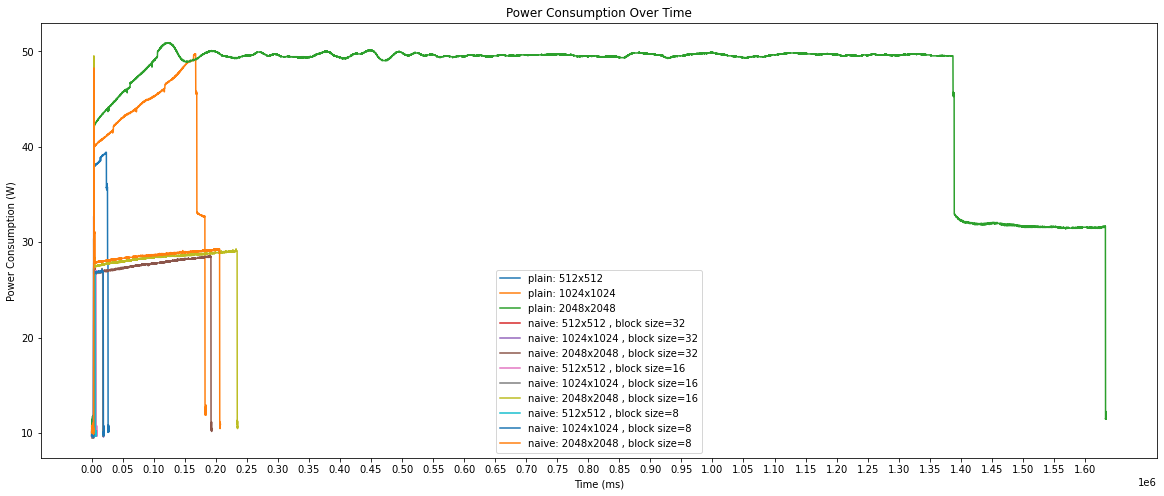

In [128]:
def plot_pwr():
    dir_name = '../data/correct/'
    xticks = {'9_32':5000, '10_32':20000, '11_32':100000,
              '9_16':5000, '10_16':20000, '11_16':100000,
              '9_8':5000, '10_8':20000, '11_8':100000}
    plain, naive, naive_A100, energy_runtime = orgranize_data(dir_name)
    plain_padded, naive_padded, times = same_size_data(plain, naive)
    gen_plot(plain_padded, naive_padded, times, 'Power Consumption Over Time')
    # compare_gpu(naive, naive_A100)
    # plot_energy_runtime(energy_runtime)
plot_pwr()

## calculate GPU utilization (current power/peak power): percentage of peak

In [ ]:
# number of threads: 32
# blocks: int BLOCKS = (N + THREADS -1) / THREADS

In [129]:
# 2^18
# 2^20
# 2^22
# each memory block is 2^2, calculate the energy use for every memory block
def get_memory_blocks(exp):
    return math.pow(2, exp*2-2)

In [130]:
block_9 = get_memory_blocks(9)
block_10 = get_memory_blocks(10)
block_11 = get_memory_blocks(11)
blocks = [block_9, block_10, block_11]
blocks

[65536.0, 262144.0, 1048576.0]

algo:naive, device:T4, size:9, threads:8, energy:119.34, normalized:43.17, baseline:10.18, runtime:1.48
algo:naive, device:T4, size:10, threads:16, energy:442.87, normalized:249.61, baseline:9.79, runtime:13.74
algo:naive, device:T4, size:11, threads:8, energy:5869.94, normalized:3751.03, baseline:10.20, runtime:201.64
algo:naive, device:T4, size:10, threads:8, energy:458.98, normalized:258.92, baseline:10.04, runtime:13.93
algo:naive, device:T4, size:9, threads:32, energy:120.81, normalized:43.72, baseline:10.38, runtime:1.43
algo:naive, device:T4, size:11, threads:32, energy:5348.52, normalized:3375.37, baseline:10.05, runtime:190.26
algo:plain, device:T4, size:10, threads:1, energy:7918.85, normalized:6005.92, baseline:10.37, runtime:178.46
algo:naive, device:T4, size:9, threads:16, energy:147.70, normalized:62.09, baseline:10.34, runtime:2.28
algo:naive, device:T4, size:11, threads:16, energy:6616.35, normalized:4228.30, baseline:10.14, runtime:229.62
algo:plain, device:T4, size:11, threads:1, energy:76178.02, normalized:58401.29, baseline:10.88, runtime:1628.32
algo:naive, device:T4, size:10, threads:32, energy:448.53, normalized:254.11, baseline:9.83, runtime:13.78
algo:plain, device:T4, size:9, threads:1, energy:924.36, normalized:638.08, baseline:10.30, runtime:21.79

In [131]:
plain_norm = [638.08, 6005.92, 58401.29]
naive_norm_32 = [43.72, 254.11, 3375.37]
naive_norm_16 = [62.09, 249.61, 4228.30]
naive_norm_8 = [43.17, 258.92, 3751.03]
naive = [naive_norm_32, naive_norm_16, naive_norm_8]

In [132]:
def calculate_energy_per_block(l, blocks):
    energy_per_block = []
    for i, b in enumerate(blocks):
        energy_per_block.append(l[i]/b)
    return energy_per_block

In [138]:
def normalize_by_naive(l, n):
    new_l = []
    for ele in l:
        new_l.append(ele/n)
    return new_l

In [139]:
def autolabel(ax, algo):
    for a in algo:
        h = a.get_height()
        ax.text(a.get_x()+a.get_width()/2., 1.05*h, '%.2f'%(h),
                ha='center', va='bottom')

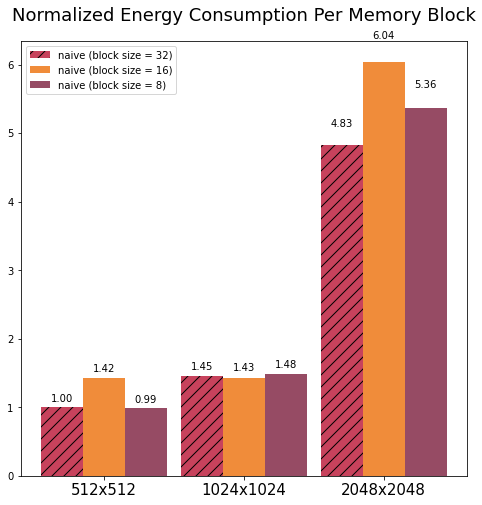

In [146]:
# bar graph grouped by size
def plot_energy_per_block():
    n = [x/blocks[i] for i, x in enumerate(naive_norm_32)]
    naive_32 = normalize_by_naive([x/blocks[i] for i, x in enumerate(naive_norm_32)], n[0])
    naive_16 = normalize_by_naive([x/blocks[i] for i, x in enumerate(naive_norm_16)], n[0])
    naive_8 = normalize_by_naive([x/blocks[i] for i, x in enumerate(naive_norm_8)], n[0])
    labels = ['512x512', '1024x1024', '2048x2048']
    
    width = 0.3
    x = np.arange(len(labels))
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    ax.set_title('Normalized Energy Consumption Per Memory Block', pad=20, fontsize=18)
    
    naive_32_ax = ax.bar(x-width, naive_32, width, label='naive (block size = 32)', hatch='//', color=np.array((199, 66, 92))/255)
    naive_16_ax = ax.bar(x, naive_16, width, label='naive (block size = 16)', color=np.array((240, 140, 58))/255)
    naive_8_ax = ax.bar(x+width, naive_8, width, label='naive (block size = 8)', color=np.array((150, 75, 100))/255)
    
    plt.xticks([0,1,2], labels, fontsize=15)
    plt.legend()
    
    autolabel(ax, naive_32_ax)
    autolabel(ax, naive_16_ax)
    autolabel(ax, naive_8_ax)

    plt.show()
    
plot_energy_per_block()

## visualization for energy use per thread

##### block size = (N + THREADS -1) / THREADS

In [149]:
def get_threads(n, thread):
    return n+thread-1

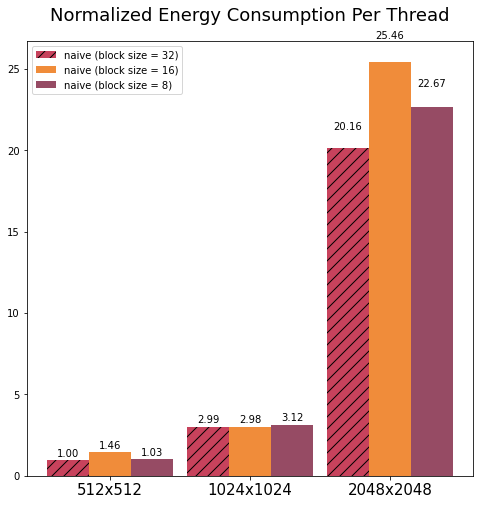

In [151]:
# bar graph grouped by size
naive_norm_32 = [43.72/get_threads(512, 32), 254.11/get_threads(1024, 32), 3375.37/get_threads(2048, 32)]
naive_norm_16 = [62.09/get_threads(512, 16), 249.61/get_threads(1024, 16), 4228.30/get_threads(2048, 16)]
naive_norm_8 = [43.17/get_threads(512, 8), 258.92/get_threads(1024, 8), 3751.03/get_threads(2048, 8)]
def plot_energy_per_thread():
    n = [x/blocks[i] for i, x in enumerate(naive_norm_32)]
    naive_32 = normalize_by_naive(naive_norm_32, naive_norm_32[0])
    naive_16 = normalize_by_naive(naive_norm_16, naive_norm_32[0])
    naive_8 = normalize_by_naive(naive_norm_8, naive_norm_32[0])
    labels = ['512x512', '1024x1024', '2048x2048']
    
    width = 0.3
    x = np.arange(len(labels))
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    ax.set_title('Normalized Energy Consumption Per Thread', pad=20, fontsize=18)
    
    naive_32_ax = ax.bar(x-width, naive_32, width, label='naive (block size = 32)', hatch='//', color=np.array((199, 66, 92))/255)
    naive_16_ax = ax.bar(x, naive_16, width, label='naive (block size = 16)', color=np.array((240, 140, 58))/255)
    naive_8_ax = ax.bar(x+width, naive_8, width, label='naive (block size = 8)', color=np.array((150, 75, 100))/255)
    
    plt.xticks([0,1,2], labels, fontsize=15)
    plt.legend()
    
    autolabel(ax, naive_32_ax)
    autolabel(ax, naive_16_ax)
    autolabel(ax, naive_8_ax)

    plt.show()
    
plot_energy_per_thread()
